In [1]:
# Required to access the database
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Data analysis tools
import pandas as pd
import numpy as np
import seaborn as sns

# Models available in our application
from datasets.models import RawFlower, RawUNM, RawDAR, RawNHANES_BIO
from django.contrib.auth.models import User
from datasets.models import RawDictionary


from datasets.models import RawNEU
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

from api import adapters

In [68]:
##merges 4 cohorts based on columns in common
def merge4CohortFrames2(df1, df2, df3,df4):
    'merge on feature intersections'

    for as_feature in ['UASB', 'UDMA', 'UAS5', 'UIAS', 'UAS3', 'UMMA']:
        if as_feature not in df1.columns:
            df1[as_feature] = np.nan
        if as_feature not in df2.columns:
            df2[as_feature] = np.nan
        if as_feature not in df3.columns:
            df3[as_feature] = np.nan

    s1 = set(df1.columns)
    s2 = set(df2.columns)
    s3 = set(df3.columns)
    s4 = set(df4.columns)

    cc = set.intersection(s1, s2, s3,s4)

    df_all = pd.concat([df1[cc],df2[cc],df3[cc], df4[cc]])

    return (df_all, cc)

In [69]:
## Get the data

## Get NEU data with no fish
df_NEU = adapters.neu.get_dataframe_orig()
df_NEU = df_NEU[df_NEU['TimePeriod']==2] # Visit 2

df_NEU_blod = adapters.neu.get_dataframe_BLOD()

df_NEU_covars = adapters.neu.get_dataframe_covars()
df_NEU = df_NEU_covars.merge(df_NEU, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates

## Get DAR data
## df_DAR = adapters.unm.get_dataframe_orig()

df_DAR = df_NEU.copy()
df_DAR['CohortType'] = 'DAR'
df_DAR_blod = df_NEU_blod.copy()
df_DAR_blod['CohortType'] = 'DAR'

## Get UNM data
'''
df_UNM = adapters.unm.get_dataframe_orig()
df_UNM_covars = adapters.unm.get_dataframe_covars()
df_UNM = df_UNM_covars.merge(df_UNM, on = ['PIN_Patient','CohortType','TimePeriod']) #Merge the covariates
'''

df_UNM = df_NEU.copy()
df_UNM['CohortType'] = 'UNM'
df_UNM_blod = df_NEU_blod.copy()
df_UNM_blod['CohortType'] = 'UNM'

## get NHANES data

df_NHANES = adapters.nhanes.get_dataframe_orig()
##get rid of name=Anlayte
df_NHANES = df_NHANES.rename_axis(None, axis=1)
df_NHANES_blod = adapters.nhanes.get_dataframe_orig_blod()
df_NHANES_covars = adapters.nhanes.get_dataframe_covars()

df_ALL, intersec_cols = merge4CohortFrames2(df_NEU, df_UNM, df_DAR, df_NHANES)


## df_ALL = analysis.merge3CohortFrames(df_NEU, df_UNM, df_DAR)
frames_for_analysis = [
    ('NEU', df_NEU),
    ('UNM', df_UNM),
    ('DAR', df_DAR),
    ('NHANES', df_NHANES),
    ('ALL', df_ALL)

]

for name, df in frames_for_analysis:
    print('Data Stats')
    print(name)
    print(df.shape)

Data Stats
NEU
(570, 55)
Data Stats
UNM
(570, 55)
Data Stats
DAR
(570, 55)
Data Stats
NHANES
(8583, 22)
Data Stats
ALL
(10293, 17)


In [70]:
## Only 247 pregnant woman in all of NHANES?

df_NHANES_covars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8744 entries, 1 to 57487
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PIN_Patient  8744 non-null   int64  
 1   Age          8744 non-null   int64  
 2   TimePeriod   8744 non-null   object 
 3   Pregnant     3917 non-null   float64
 4   Marital      7583 non-null   float64
 5   Child_A      8744 non-null   int64  
 6   Child_B      8744 non-null   int64  
 7   H_Inc        8503 non-null   float64
 8   F_Inc        8519 non-null   float64
 9   Edu          7583 non-null   float64
 10  Rac          8744 non-null   int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 819.8+ KB


In [71]:
## Comments:
## While you have 243 total participants, it varies per analyte.
## UALB_mg is not a harmonized variable: #df['UALB'] = df['UALB_mg'] * converversion
## UCRT_mg is not a harmonized variable
## UCRT_unmol is not a harmonized varaible



df_NHANES_blod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652 entries, 0 to 8651
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PIN_Patient  8652 non-null   int64  
 1   TimePeriod   8652 non-null   object 
 2   UALB_mg      6376 non-null   float64
 3   UALB_ug      6376 non-null   float64
 4   UBA          2893 non-null   float64
 5   UCD          2893 non-null   float64
 6   UCO          2893 non-null   float64
 7   UCR          621 non-null    float64
 8   UCRT_mg      4055 non-null   float64
 9   UCRT_umol    4055 non-null   float64
 10  UCS          2893 non-null   float64
 11  UHG          2895 non-null   float64
 12  UI           1354 non-null   float64
 13  UMN          2893 non-null   float64
 14  UMO          2892 non-null   float64
 15  UNI          621 non-null    float64
 16  UPB          2893 non-null   float64
 17  USB          2893 non-null   float64
 18  USN          2892 non-null   float64
 19  UTL   

**Summary Statistics**

In [72]:
##limit summary statistic values to two decimal places
def clean_cols(desc_DF):
    desc_DF["count"]=desc_DF["count"].astype(int)
    desc_DF["mean"]=round(desc_DF["mean"],2)
    desc_DF["std"]=round(desc_DF["std"],2)
    desc_DF["min"]=round(desc_DF["min"],2)
    desc_DF["25%"]=round(desc_DF["25%"],2)
    desc_DF["50%"]=round(desc_DF["50%"],2)
    desc_DF["75%"]=round(desc_DF["75%"],2)
    desc_DF["max"]=round(desc_DF["max"],2)

def desc_4_cohs(df_neu, df_dar, df_unm, df_nhanes, fi_name):
    ##columns to describe
    desc_cols = []
    for col in df_ALL.columns:
        if col not in ['PIN_Patient', 'TimePeriod', 'CohortType']:
            desc_cols.append(col)
    # NEU
    desc_neu = df_neu[desc_cols].describe().transpose()
    clean_cols(desc_neu)

    # DAR 
    desc_dar = df_dar[desc_cols].describe().transpose()
    clean_cols(desc_dar)

    # UNM
    desc_unm = df_unm[desc_cols].describe().transpose()
    clean_cols(desc_unm)

    # NHANES
    desc_nhanes = df_nhanes[desc_cols].describe().transpose()
    clean_cols(desc_nhanes)

    #Saving each summary dataframe to a csv file.
    frames_names = [(desc_neu,"NEU"), (desc_dar, "DAR"),(desc_unm,"UNM"), (desc_nhanes,"NHANES")]


    try:
        f = open(fi_name+".csv", "x")
        f = open(fi_name+".csv", "a")

    except:
        f = open(fi_name+".csv", "a")

    for tup in frames_names:
        frame=tup[0]
        name=tup[1]
        ##content=string(name ,"/n",frame,"\n\n")
        f.write(name + ',')
        f.write("\n\t")
        f.write(str(frame) + ',')
        f.write("\n\n")

    f.close()
    return frames_names, desc_cols


In [73]:
frames_names, desc_cols = desc_4_cohs(df_NEU, df_DAR, df_UNM, df_NHANES, "Summary_Stats_DP_Paper_JGeller")

In [74]:
def df_to_log_cols(df, not_cols):
    df_res = df.copy()
    for col in df_res.columns:
        if col not in not_cols:
            df_res[col] = np.log10(df[col])
    return df_res

In [75]:
not_cols = ['PIN_Patient', 'CohortType', 'TimePeriod', 'Outcome_weeks', 'age',
       'ethnicity', 'race', 'Outcome', 'BMI', 'smoking', 'parity',
       'preg_complications', 'ga_collection', 'folic_acid_supp', 'fish',
       'babySex', 'birthWt', 'birthLen', 'headCirc', 'WeightCentile', 'LGA',
       'SGA', 'education', 'birth_year', 'SPECIFICGRAVITY_V2', 'fish_pu_v2',
       'Member_c']
df_NEU_log = df_to_log_cols(df_NEU, not_cols)
df_NEU_log.head(5)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PIN_Patient,CohortType,TimePeriod,Outcome_weeks,age,ethnicity,race,Outcome,BMI,smoking,...,UTU,UUR,UVA,UZN,UASB,UDMA,UAS5,UIAS,UAS3,UMMA
0,2070,NEU,2,38.285714,33.0,1.0,1.0,0.0,26.50,0.0,...,-0.850781,-2.154902,-0.372634,2.419672,NaN,NaN,NaN,NaN,NaN,NaN
1,2092,NEU,2,39.571429,21.0,1.0,6.0,0.0,23.03,0.0,...,-0.850781,-2.154902,-0.372634,2.613839,NaN,NaN,NaN,NaN,NaN,NaN
2,2107,NEU,2,39.285714,20.0,1.0,3.0,0.0,29.65,0.0,...,-0.850781,-2.154902,-0.372634,2.651798,NaN,NaN,NaN,NaN,NaN,NaN
3,2115,NEU,2,36.285714,29.0,1.0,6.0,1.0,29.57,0.0,...,-0.850781,-2.154902,-0.372634,2.146940,NaN,NaN,NaN,NaN,NaN,NaN
4,2119,NEU,2,39.571429,25.0,1.0,6.0,0.0,28.52,0.0,...,-0.645892,-2.154902,-0.372634,2.351141,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
not_cols = ['PIN_Patient', 'CohortType', 'TimePeriod', 'Outcome_weeks', 'age',
       'ethnicity', 'race', 'Outcome', 'BMI', 'smoking', 'parity',
       'preg_complications', 'ga_collection', 'folic_acid_supp', 'fish',
       'babySex', 'birthWt', 'birthLen', 'headCirc', 'WeightCentile', 'LGA',
       'SGA', 'education', 'birth_year', 'SPECIFICGRAVITY_V2', 'fish_pu_v2',
       'Member_c']
df_DAR_log = df_to_log_cols(df_DAR, not_cols)
df_DAR_log.head(5)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PIN_Patient,CohortType,TimePeriod,Outcome_weeks,age,ethnicity,race,Outcome,BMI,smoking,...,UTU,UUR,UVA,UZN,UASB,UDMA,UAS5,UIAS,UAS3,UMMA
0,2070,DAR,2,38.285714,33.0,1.0,1.0,0.0,26.50,0.0,...,-0.850781,-2.154902,-0.372634,2.419672,NaN,NaN,NaN,NaN,NaN,NaN
1,2092,DAR,2,39.571429,21.0,1.0,6.0,0.0,23.03,0.0,...,-0.850781,-2.154902,-0.372634,2.613839,NaN,NaN,NaN,NaN,NaN,NaN
2,2107,DAR,2,39.285714,20.0,1.0,3.0,0.0,29.65,0.0,...,-0.850781,-2.154902,-0.372634,2.651798,NaN,NaN,NaN,NaN,NaN,NaN
3,2115,DAR,2,36.285714,29.0,1.0,6.0,1.0,29.57,0.0,...,-0.850781,-2.154902,-0.372634,2.146940,NaN,NaN,NaN,NaN,NaN,NaN
4,2119,DAR,2,39.571429,25.0,1.0,6.0,0.0,28.52,0.0,...,-0.645892,-2.154902,-0.372634,2.351141,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
not_cols = ['PIN_Patient', 'CohortType', 'TimePeriod', 'Outcome_weeks', 'age',
       'ethnicity', 'race', 'Outcome', 'BMI', 'smoking', 'parity',
       'preg_complications', 'ga_collection', 'folic_acid_supp', 'fish',
       'babySex', 'birthWt', 'birthLen', 'headCirc', 'WeightCentile', 'LGA',
       'SGA', 'education', 'birth_year', 'SPECIFICGRAVITY_V2', 'fish_pu_v2',
       'Member_c']
df_UNM_log = df_to_log_cols(df_UNM, not_cols)
df_UNM_log.head(5)

/usr/local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PIN_Patient,CohortType,TimePeriod,Outcome_weeks,age,ethnicity,race,Outcome,BMI,smoking,...,UTU,UUR,UVA,UZN,UASB,UDMA,UAS5,UIAS,UAS3,UMMA
0,2070,UNM,2,38.285714,33.0,1.0,1.0,0.0,26.50,0.0,...,-0.850781,-2.154902,-0.372634,2.419672,NaN,NaN,NaN,NaN,NaN,NaN
1,2092,UNM,2,39.571429,21.0,1.0,6.0,0.0,23.03,0.0,...,-0.850781,-2.154902,-0.372634,2.613839,NaN,NaN,NaN,NaN,NaN,NaN
2,2107,UNM,2,39.285714,20.0,1.0,3.0,0.0,29.65,0.0,...,-0.850781,-2.154902,-0.372634,2.651798,NaN,NaN,NaN,NaN,NaN,NaN
3,2115,UNM,2,36.285714,29.0,1.0,6.0,1.0,29.57,0.0,...,-0.850781,-2.154902,-0.372634,2.146940,NaN,NaN,NaN,NaN,NaN,NaN
4,2119,UNM,2,39.571429,25.0,1.0,6.0,0.0,28.52,0.0,...,-0.645892,-2.154902,-0.372634,2.351141,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
not_cols = ['PIN_Patient', 'CohortType', 'TimePeriod', 'Outcome_weeks', 'age',
       'ethnicity', 'race', 'Outcome', 'BMI', 'smoking', 'parity',
       'preg_complications', 'ga_collection', 'folic_acid_supp', 'fish',
       'babySex', 'birthWt', 'birthLen', 'headCirc', 'WeightCentile', 'LGA',
       'SGA', 'education', 'birth_year', 'SPECIFICGRAVITY_V2', 'fish_pu_v2',
       'Member_c']
df_NHANES_log = df_to_log_cols(df_NHANES, not_cols)
df_NHANES_log.head(5)

,PIN_Patient,TimePeriod,UALB_mg,UALB_ug,UBA,UCD,UCO,UCR,UCRT_mg,UCRT_umol,...,UI,UMN,UMO,UNI,UPB,USB,USN,UTL,UTU,CohortType
0,62161,2011-12,0.716003,0.716003,NaN,NaN,NaN,NaN,2.127105,4.073557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
1,62169,2011-12,0.880814,0.880814,-0.236572,-0.943095,-0.515700,NaN,2.176091,4.122544,...,2.503109,2.152288,2.152288,NaN,-0.327902,-1.537602,-0.455932,-0.679854,-0.193820,NHANES
2,62176,2011-12,0.799341,0.799341,NaN,NaN,NaN,NaN,1.982271,3.928723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
3,62180,2011-12,0.278754,0.278754,NaN,NaN,NaN,NaN,1.531479,3.477931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NHANES
4,62184,2011-12,1.447158,1.447158,0.518514,-0.677781,-0.364516,NaN,2.482874,4.429326,...,1.865696,1.870404,1.870404,NaN,-0.167491,-1.017729,0.478566,-0.423659,-1.008774,NHANES


In [79]:
frames_names, desc_cols = desc_4_cohs(df_NEU_log, df_DAR_log, df_UNM_log, df_NHANES_log, 'Summary_Stats_Log_Values_DP_Paper_JGeller')

**Reporting of the counts per analyte provided by each cohort**


In [80]:
##returns a dict with count per analyte
def count_dict(frame_name):
    ##build dictionary with values coressponding to each column
    vals = {}
    desc_cols.append('CohortType')
    for col in desc_cols:
        vals[col] = []

    ##report ocunts for each data frame and add values to dictionary
    for tup in frame_name:
        i = 0
        name=tup[1]
        vals["CohortType"].append(name)

        while i < len(tup[0]):
            feature = tup[0].index[i]
            feature_count = tup[0]["count"][i]
            i = i + 1
            vals[feature].append(feature_count)

    ##create dataframe from values in dictionary
    return pd.DataFrame(columns = list(vals.keys()), data = vals)

In [81]:
counts = count_dict(frames_names)

In [16]:
# Displaying counts in a dataframe with a gradient based on value
import seaborn as sns
cm = sns.light_palette("pink", as_cmap = True)
counts_df= counts.style.background_gradient(cmap = cm)
counts_df

##TAKE SCREENSHOT

,UHG,UCD,UNI,USN,UPB,UMO,UTU,UTL,USB,UMN,UCS,UCO,UCR,UBA,CohortType
0,566,570,570,570,570,570,570,570,570,570,570,570,570,570,NEU
1,566,570,570,570,570,570,570,570,570,570,570,570,570,570,DAR
2,566,570,570,570,570,570,570,570,570,570,570,570,570,570,UNM
3,2895,2893,621,2892,2893,2892,2887,2893,2893,2893,2893,2893,621,2893,NHANES


**Making a Histogram of Counts per Analyte**

In [82]:
##creates a seaborn histogram based on a melted df and color scheme
def hist(df_melted, list_colors, fi_name):
    sns.set_style('ticks')
    
    g = sns.catplot(
        data = df_melted,
        x = 'CohortType', y = 'value',
        col ='variable', kind = 'bar', col_wrap = 5, sharey = False, palette = list_colors
    )
    # iterate through axes and set bar label as number of datapoints
    for ax in g.axes.ravel():

        # add annotations
        for c in ax.containers:
            labels = [f'{(v.get_height()):.0f}' for v in c]
            ax.bar_label(c, labels=labels, label_type = 'edge')
        ax.margins(y = 0.2)

    g.savefig(fi_name, format ='jpeg', dpi =1000)


In [83]:
counts_melted = pd.melt(counts, id_vars = ['CohortType'])

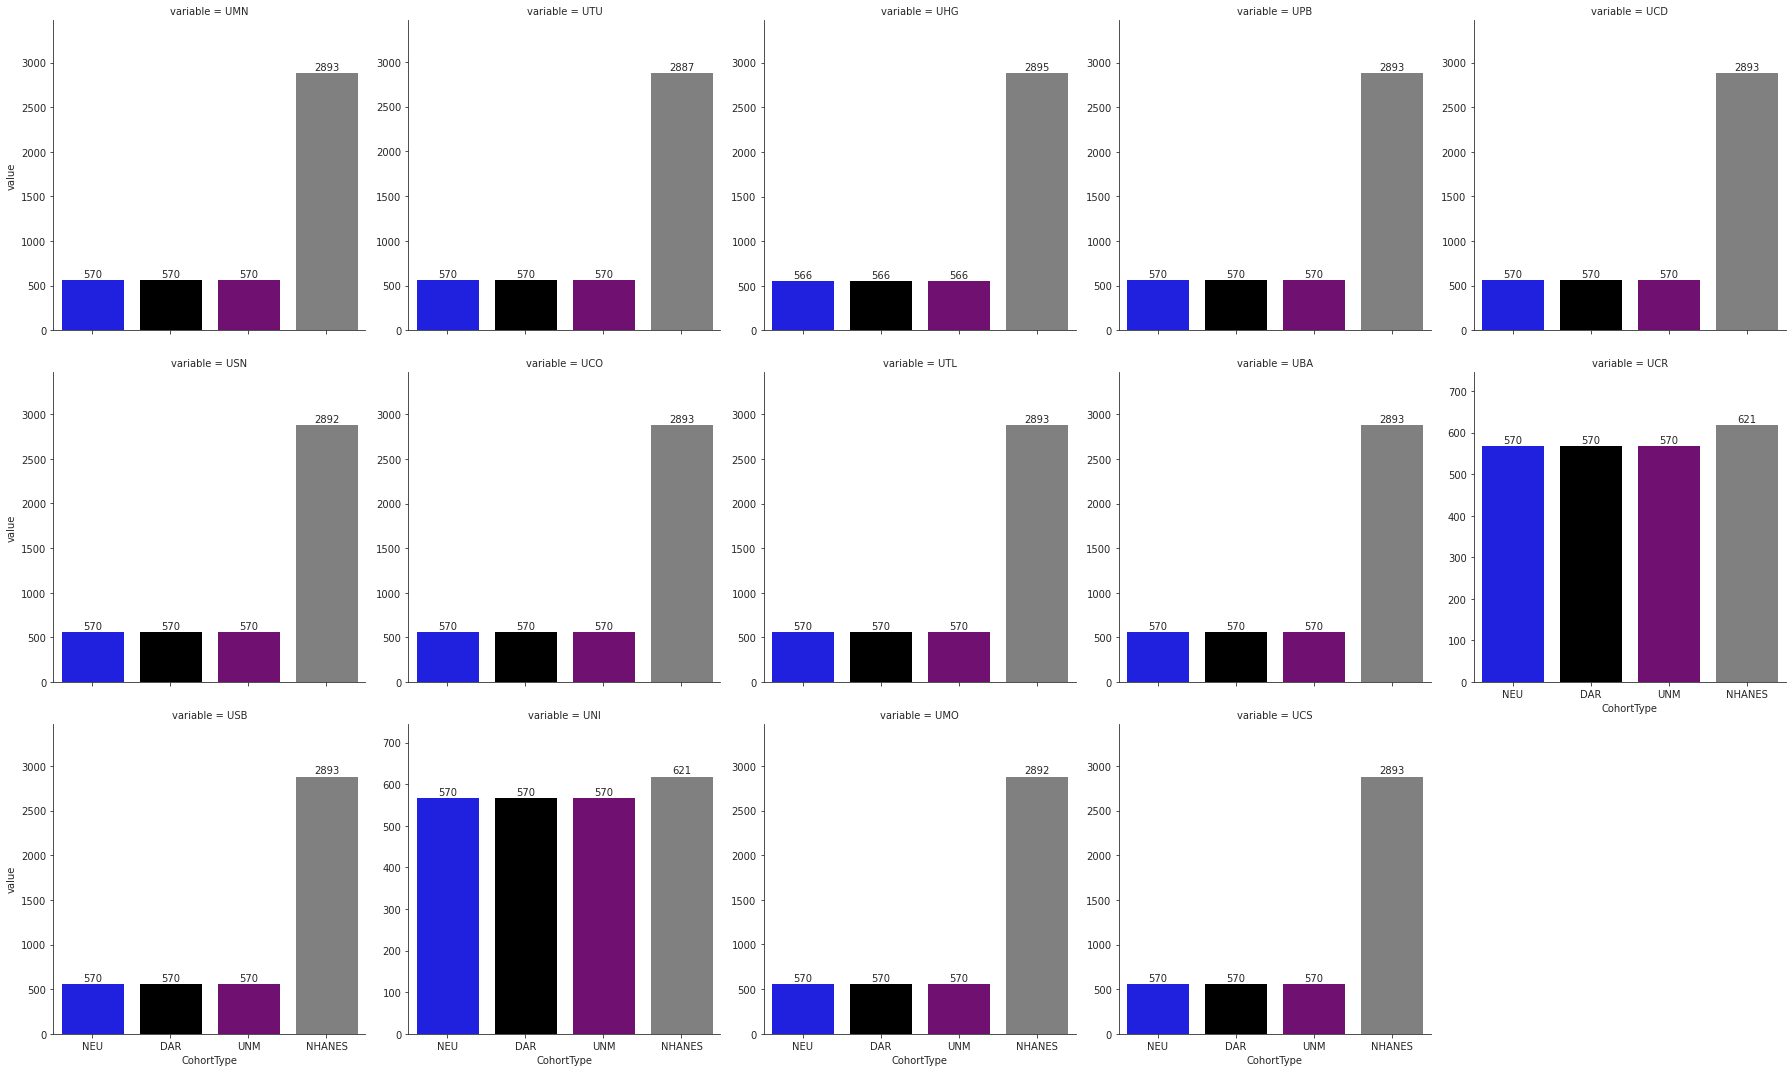

In [13]:
hist(counts_melted, ['blue', 'black', 'purple', 'gray'], 'Analyte_Counts_Hist_DP_Paper.jpg')

**Creating Graph of Distributions**

In [84]:
##creating dataframe to create a boxplot
def long_on_analyte(df_neu, df_dar, df_unm, df_nhanes, intersec_cols):
    cols = intersec_cols.copy()
    cols.remove('PIN_Patient')
    cols.remove('TimePeriod')
    neu_ints_melt = pd.melt(df_neu[cols], id_vars = "CohortType")
    dar_ints_melt = pd.melt(df_dar[cols], id_vars = "CohortType")
    unm_ints_melt = pd.melt(df_unm[cols], id_vars = "CohortType")
    nhanes_ints_melt = pd.melt(df_nhanes[cols], id_vars = "CohortType")
    return pd.concat([neu_ints_melt, dar_ints_melt, unm_ints_melt, nhanes_ints_melt], axis = 0)

In [85]:
all_combined_stacks_melts = long_on_analyte(df_NEU, df_DAR, df_UNM, df_NHANES, intersec_cols)
all_combined_stacks_melts

,CohortType,variable,value
0,NEU,UCR,0.283
1,NEU,UCR,0.460
2,NEU,UCR,0.283
3,NEU,UCR,0.283
4,NEU,UCR,0.283
...,...,...,...
120157,NHANES,USB,NaN
120158,NHANES,USB,NaN
120159,NHANES,USB,0.032
120160,NHANES,USB,0.059


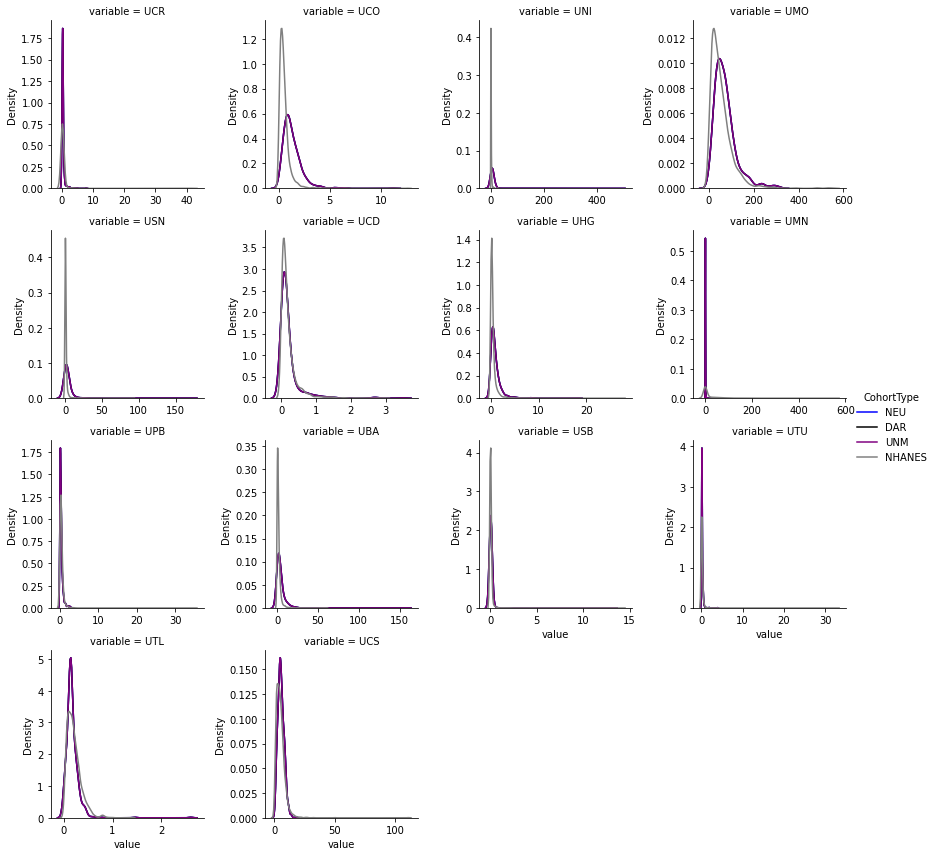

In [53]:
# Distribution Plot on Analyte
g = sns.FacetGrid(all_combined_stacks_melts, col = 'variable', hue = 'CohortType', col_wrap = 4, sharex = False, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])
p1 = g.map(sns.kdeplot, 'value').add_legend()
p1.savefig('Dist_Plot_DP_Paper.jpg', format = 'jpeg', dpi = 1000)


In [87]:
all_combined_stacks_melts_log = all_combined_stacks_melts.copy()
all_combined_stacks_melts_log = long_on_analyte(df_NEU_log, df_DAR_log, df_UNM_log, df_NHANES_log, intersec_cols)
all_combined_stacks_melts_log.head(5)

,CohortType,variable,value
0,NEU,UCR,-0.548214
1,NEU,UCR,-0.337242
2,NEU,UCR,-0.548214
3,NEU,UCR,-0.548214
4,NEU,UCR,-0.548214


In [76]:
all_combined_stacks_melts_log

,CohortType,variable,value,log_value
0,NEU,UHG,4.504,0.653598
1,NEU,UHG,1.552,0.190892
2,NEU,UHG,0.680,-0.167491
3,NEU,UHG,1.267,0.102777
4,NEU,UHG,0.329,-0.482804
...,...,...,...,...
120157,NHANES,UBA,NaN,NaN
120158,NHANES,UBA,NaN,NaN
120159,NHANES,UBA,0.680,-0.167491
120160,NHANES,UBA,4.730,0.674861


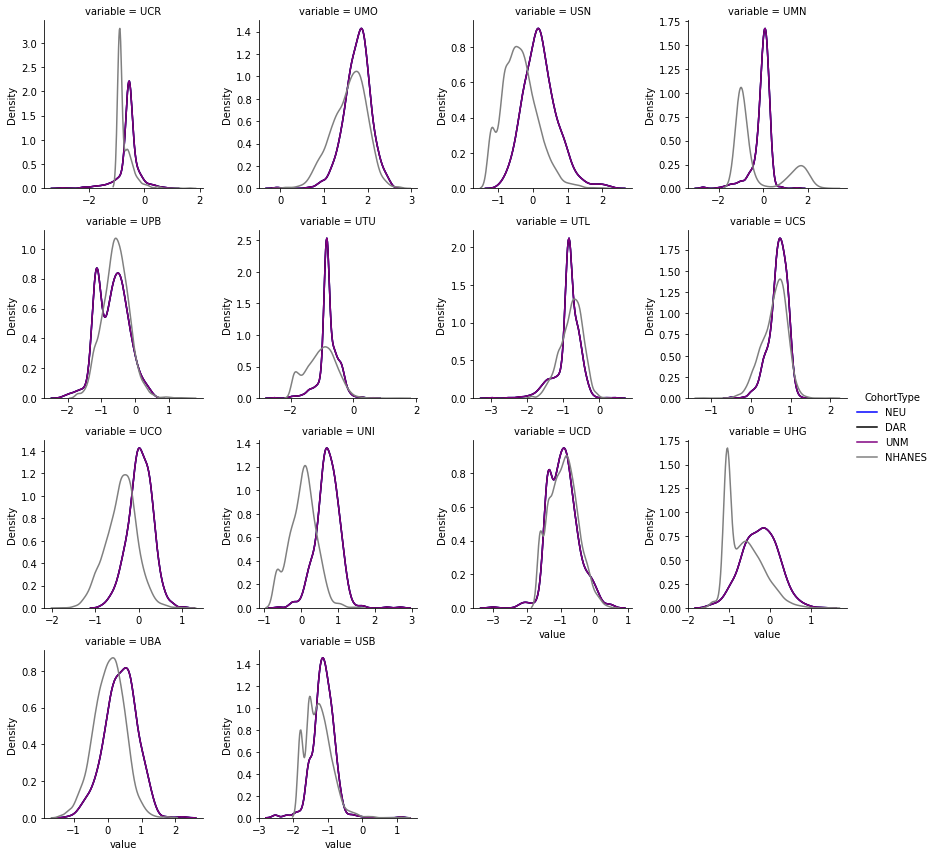

In [89]:
# Distribution Plot on log analyte value

g = sns.FacetGrid(all_combined_stacks_melts_log, col = 'variable', hue = 'CohortType', col_wrap = 4, sharex = False, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])
p1 = g.map(sns.kdeplot, 'value').add_legend()
p1.savefig('Dist_Plot_Log_Analyte_DP_Paper.jpg', format = 'jpeg', dpi = 1000)

**Creating Boxplots**

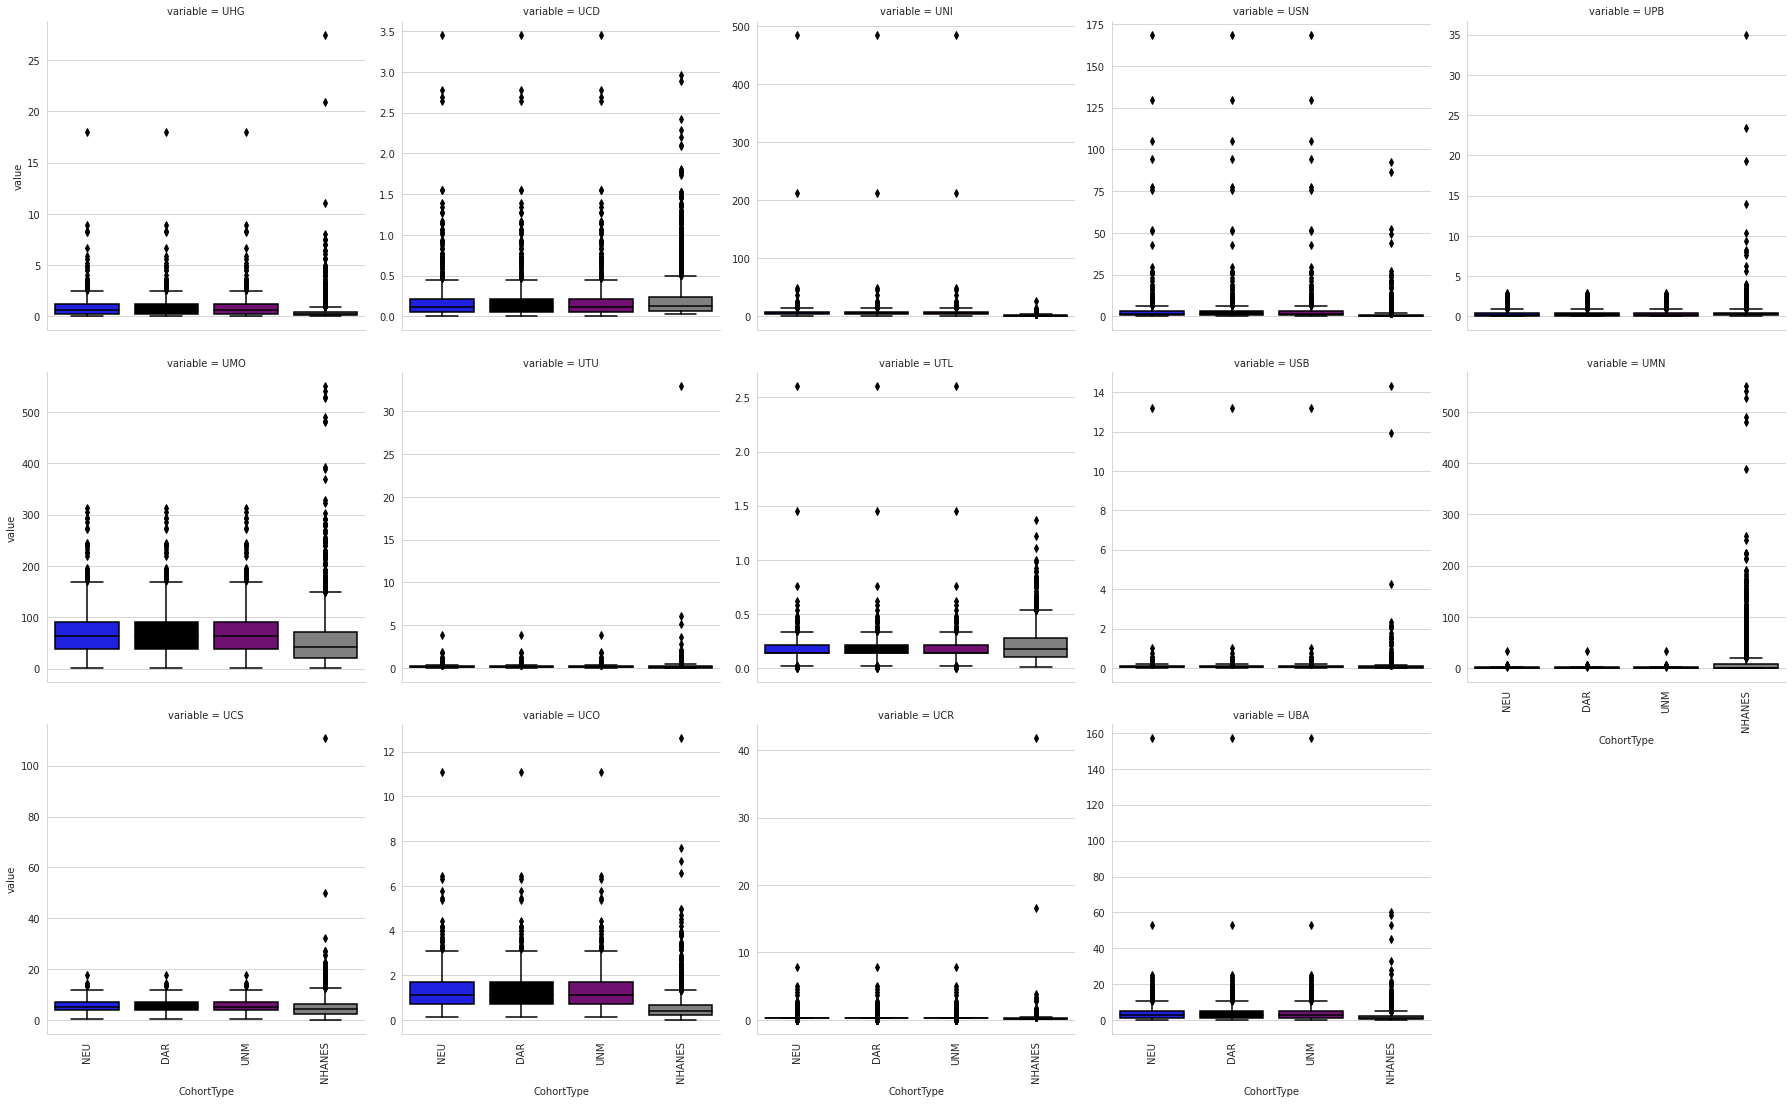

In [22]:
##boxplopts on analyte value
sns.set_style('whitegrid')

plot_df = all_combined_stacks_melts[all_combined_stacks_melts['CohortType'].isin(['NEU','DAR','UNM', 'NHANES'])]
g = sns.catplot(
    data = plot_df,
    x = 'CohortType', y ='value',
    col ='variable', kind ='box', col_wrap = 5, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])

# set rotation
g.set_xticklabels(rotation=90)

g.savefig('Boxplots_DP_Paper.jpg', format = 'jpeg', dpi = 1000)

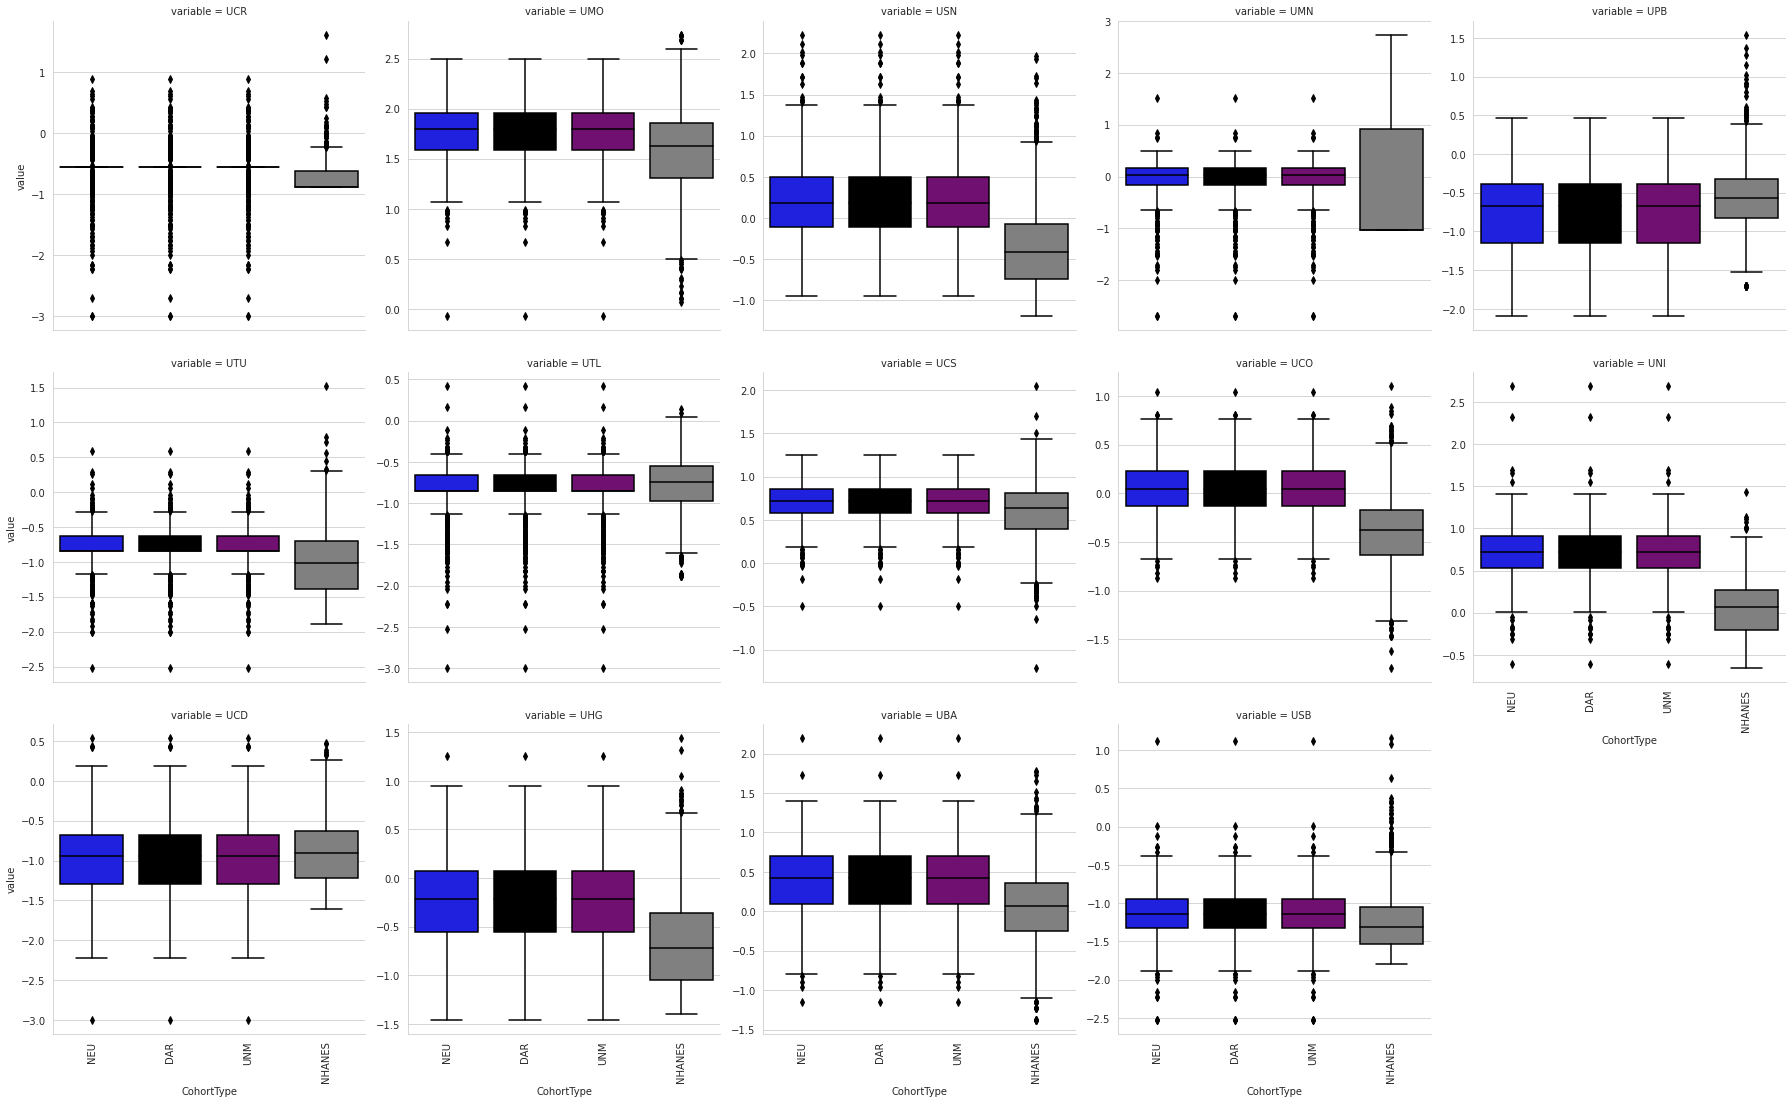

In [90]:
##boxplopts on log analyte value
sns.set_style('whitegrid')

plot_log_df= all_combined_stacks_melts_log[all_combined_stacks_melts_log['CohortType'].isin(['NEU','DAR','UNM', 'NHANES'])]
g = sns.catplot(
    data = plot_log_df,
    x = 'CohortType', y ='value',
    col ='variable', kind ='box', col_wrap = 5, sharey = False, palette = ['blue', 'black', 'purple', 'gray'])

# set rotation
g.set_xticklabels(rotation=90)

g.savefig('Boxplots_Log_Analyte_DP_Paper.jpg', format = 'jpeg', dpi = 1000)

**BLOD Bar Graphs**

In [23]:
##returns a count of how many above limit of dection values per analyte
def count_blod(df):
    cohs = []
    var = []
    val = []
    for col in df.columns:
        if col not in ['Analyte', 'PIN_Patient', 'TimePeriod', 'Member_c', 'Outcome', 'CohortType']:
            cohs.append(df['CohortType'][0])
            var.append(col)
            ##less than 0.01 becaue NHANES has 0.00000001 to mean 0.0
            val.append(df[df[col] < 0.01]['PIN_Patient'].nunique())
    return pd.DataFrame({'CohortType' : cohs, 'variable' : var, 'value' : val})
        

In [24]:
df_NEU_blod_count = count_blod(df_NEU_blod)
df_DAR_blod_count = count_blod(df_DAR_blod)
df_UNM_blod_count = count_blod(df_UNM_blod)
df_NHANES_blod_count = count_blod(df_NHANES_blod)


In [ ]:
import seaborn as sns
all_combined_blod = pd.concat([df_NEU_blod_count, df_DAR_blod_count, df_UNM_blod_count, df_NHANES_blod_count])

hist(all_combined_blod, ['blue', 'black', 'purple', 'gray'], 'Blod_Hist_DP_Paper.jpg')


**TODO**

**1. box plots**

2. finsih other stats test
3. bar plot lod's

**One-Way Anova of Geometric Means**

Meeting assumptions

1. Normally distributed: over 30 datapoints so Central Limit Theorem says they are normally distributed
2. Independent Groups: met by structure of data
3. Homogeneity of Variances (equal variances): will be tested for each analyte group

Source: https://online.stat.psu.edu/stat200/lesson/10/10.2

In [92]:
import statistics as stat
from scipy.stats import f_oneway
from statistics import variance

##get colors to print in color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

##conduct a one way anova of all analytes
def one_way_anova(df_all, fi_name):
    ##define lists that report results of anova
    analytes = []
    assumptions = []
    p_vals = []
    sig = []
    variances = []

    for col in df_ALL.columns:
        if col not in ['TimePeriod', 'CohortType', 'PIN_Patient']:
            analytes.append(col)
            ##get series of analyte values w/out NaN
            NEU = df_ALL[df_ALL['CohortType'] == 'NEU'][col].dropna()
            UNM = df_ALL[df_ALL['CohortType'] == 'UNM'][col].dropna()
            DAR = df_ALL[df_ALL['CohortType'] == 'DAR'][col].dropna()
            NHANES = df_ALL[df_ALL['CohortType'] == 'NHANES'][col].dropna()
            var = [round(variance(NEU),3), round(variance(DAR),3), round(variance(UNM),3), round(variance(NHANES),3)]
            variances.append(var)
            ##if equal variances, conduct anova
            ##if round(variance(NEU), 2) == round(variance(UNM), 2) == round(variance(DAR), 2) == round(variance(NHANES), 2):
            if max(var) / min(var) < 2:
                print(bcolors.OKGREEN + col, "passes assumptions" + bcolors.OKGREEN, '\n')
                assumptions.append(True)

            else:                     
                print(bcolors.FAIL + col, "fails: unequal variances" + bcolors.FAIL)
                assumptions.append(False)
                    #perform one-way ANOVA
            p = f_oneway(NEU , UNM ,DAR , NHANES).pvalue
            p_vals.append(p)
            if p > 0.05:
                sig.append(False)
            else:
                sig.append(True)
    ##make df from results of anova
    data = {'Analytes' : analytes, 'Passes Equal Variance Assumption' : assumptions, 'P-Value' : p_vals, 
            'Significant' : sig, 'Variance' : variances}
    res_df = pd.DataFrame(data)
    res_df.to_csv(fi_name, index = False)
    return res_df

In [94]:
anova_df = one_way_anova(df_ALL, 'one_way_anova_results.csv')
anova_df

UCR fails: unequal variances
UCO fails: unequal variances
UNI fails: unequal variances
UMO passes assumptions 

USN fails: unequal variances
UCD passes assumptions 

UHG passes assumptions 

UMN fails: unequal variances
UPB fails: unequal variances
UBA fails: unequal variances
USB fails: unequal variances
UTU fails: unequal variances
UTL passes assumptions 

UCS fails: unequal variances


,Analytes,Passes Equal Variance Assumption,P-Value,Significant,Variance
0,UCR,False,7.518585e-01,False,"[0.325, 0.325, 0.325, 3.311]"
1,UCO,False,5.866192e-223,True,"[0.931, 0.931, 0.931, 0.348]"
2,UNI,False,1.313985e-09,True,"[499.628, 499.628, 499.628, 3.317]"
3,UMO,True,2.194844e-29,True,"[2510.174, 2510.174, 2510.174, 2618.08]"
4,USN,False,1.095662e-34,True,"[153.349, 153.349, 153.349, 11.596]"
5,UCD,True,8.953400e-01,False,"[0.106, 0.106, 0.106, 0.063]"
6,UHG,True,8.092685e-52,True,"[1.672, 1.672, 1.672, 0.884]"
7,UMN,False,4.810211e-47,True,"[2.299, 2.299, 2.299, 1476.996]"
8,UPB,False,6.949066e-03,True,"[0.173, 0.173, 0.173, 1.088]"
9,UBA,False,1.865887e-45,True,"[63.014, 63.014, 63.014, 9.117]"


In [139]:
## One way Anova on log analyte values

##get colors to print in color
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

##conduct a one way anova of all analytes
def one_way_anova_log(df_all):
    ##define lists that report results of anova
    analytes = []
    assumptions = []
    p_vals = []
    sig = []
    variances = []

    for col in df_all.columns:
        if col not in ['TimePeriod', 'CohortType', 'PIN_Patient']:
            analytes.append(col)
            NEU = df_ALL[df_ALL['CohortType']=='NEU'].dropna(subset = [col])
            NEU = NEU[NEU[col] != 0.0]
            NEU = NEU[col].apply(lambda x : math.log(x, 10))
            
            DAR = df_ALL[df_ALL['CohortType']=='DAR'].dropna(subset = [col])
            DAR = DAR[DAR[col] != 0.0]
            DAR =DAR[col].apply(lambda x : math.log(x, 10))

            UNM = df_ALL[df_ALL['CohortType']=='UNM'].dropna(subset = [col])
            UNM = UNM[UNM[col] != 0.0]
            UNM =UNM[col].apply(lambda x : math.log(x, 10))

            NHANES = df_ALL[df_ALL['CohortType']=='NHANES'].dropna(subset = [col])
            NHANES = NHANES[NHANES[col] != 0.0]
            NHANES = NHANES[col].apply(lambda x : math.log(x, 10))
            
            var = [round(variance(NEU),3), round(variance(DAR),3), round(variance(UNM),3), round(variance(NHANES),3)]
            variances.append(var)
            if max(var) / min(var) < 2:
                print(bcolors.OKGREEN + col, "passes assumptions" + bcolors.OKGREEN, '\n')
                assumptions.append(True)

            else:                     
                print(bcolors.FAIL + col, "fails: unequal variances" + bcolors.FAIL)
                assumptions.append(False)
                    #perform one-way ANOVA
            p = f_oneway(NEU , UNM ,DAR , NHANES).pvalue
            p_vals.append(p)
            if p > 0.05:
                sig.append(False)
            else:
                sig.append(True)
    ##make df from results of anova
    data = {'Analytes' : analytes, 'Passes Equal Variance Assumption' : assumptions, 'P-Value' : p_vals, 
            'Significant' : sig, 'Variance' : variances}
    res_df = pd.DataFrame(data)
    res_df.to_csv('one_way_anova_log_results.csv', index = False)
    return res_df

In [140]:
anova_log_df = one_way_anova_log(df_ALL)
anova_log_df

UCR fails: unequal variances
UCO passes assumptions 

UNI passes assumptions 

UMO passes assumptions 

USN passes assumptions 

UCD passes assumptions 

UHG passes assumptions 

UMN fails: unequal variances
UPB passes assumptions 

UBA passes assumptions 

USB passes assumptions 

UTU fails: unequal variances
UTL passes assumptions 

UCS passes assumptions 



,Analytes,Passes Equal Variance Assumption,P-Value,Significant,Variance
0,UCR,False,5.518712e-16,True,"[0.17, 0.17, 0.17, 0.08]"
1,UCO,True,0.000000e+00,True,"[0.079, 0.079, 0.079, 0.128]"
2,UNI,True,1.729483e-292,True,"[0.105, 0.105, 0.105, 0.129]"
3,UMO,True,8.716046e-62,True,"[0.092, 0.092, 0.092, 0.156]"
4,USN,True,3.489979e-286,True,"[0.246, 0.246, 0.246, 0.251]"
5,UCD,True,7.477155e-01,False,"[0.189, 0.189, 0.189, 0.176]"
6,UHG,True,4.175925e-183,True,"[0.193, 0.193, 0.193, 0.19]"
7,UMN,False,8.704591e-11,True,"[0.171, 0.171, 0.171, 1.304]"
8,UPB,True,1.627625e-14,True,"[0.202, 0.202, 0.202, 0.156]"
9,UBA,True,5.703676e-119,True,"[0.221, 0.221, 0.221, 0.201]"


In [165]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
##post hoc tests on analytes that were found to be significantly different by ANOVA
##if p < 0.05,there is a statistically significant difference in means
def tukey(df_neu, df_dar, df_unm, df_nhanes, cols_to_test):
    for col in cols_to_test:
        NEU = df_ALL[df_ALL['CohortType']=='NEU'].dropna(subset = [col])
        DAR = df_ALL[df_ALL['CohortType']=='DAR'].dropna(subset = [col])
        UNM = df_ALL[df_ALL['CohortType']=='UNM'].dropna(subset = [col])
        NHANES = df_ALL[df_ALL['CohortType']=='NHANES'].dropna(subset = [col])
        df = pd.concat([NEU, DAR, UNM, NHANES])
        tukey = pairwise_tukeyhsd(endog = df[col],
                                  groups = df['CohortType'],
                                  alpha=0.05)
        file_name = 'tukey_results.csv'
        try:
            f = open(file_name, 'x')
            f = open(file_name, 'x')

        except:
            f = open(file_name, 'a')
            f.write(col + ' Tukey Result: \n')
            f.write(str(tukey))
            f.write('\n\n')

        f.close()
    return print(str(tukey))

In [169]:
cols_to_test = anova_df['Analytes']
tukey(df_NEU, df_DAR, df_UNM, df_NHANES, cols_to_test)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   DAR    NEU      0.0    1.0 -0.5276  0.5276  False
   DAR NHANES   -0.611 0.0007 -1.0191 -0.2029   True
   DAR    UNM      0.0    1.0 -0.5276  0.5276  False
   NEU NHANES   -0.611 0.0007 -1.0191 -0.2029   True
   NEU    UNM      0.0    1.0 -0.5276  0.5276  False
NHANES    UNM    0.611 0.0007  0.2029  1.0191   True
----------------------------------------------------


In [167]:
##post hoc tests on log of analytes that were found to be significantly different by ANOVA
##if p < 0.05,there is a statistically significant difference in means

def tukey_log(df_neu, df_dar, df_unm, df_nhanes, cols_to_test):
    for col in cols_to_test:
        NEU = df_ALL[df_ALL['CohortType']=='NEU'].dropna(subset = [col])
        NEU = NEU[NEU[col] != 0.0]
        NEU[col] = NEU[col].apply(lambda x : math.log(x, 10))
        DAR = df_ALL[df_ALL['CohortType']=='DAR'].dropna(subset = [col])
        DAR = DAR[DAR[col] != 0.0]
        DAR[col] =DAR[col].apply(lambda x : math.log(x, 10))
        
        UNM = df_ALL[df_ALL['CohortType']=='UNM'].dropna(subset = [col])
        UNM = UNM[UNM[col] != 0.0]
        UNM[col] =UNM[col].apply(lambda x : math.log(x, 10))
        
        NHANES = df_ALL[df_ALL['CohortType']=='NHANES'].dropna(subset = [col])
        NHANES = NHANES[NHANES[col] != 0.0]
        NHANES[col] = NHANES[col].apply(lambda x : math.log(x, 10))
        
        df = pd.concat([NEU, DAR, UNM, NHANES])
        tukey = pairwise_tukeyhsd(endog = df[col],
                                  groups = df['CohortType'],
                                  alpha=0.05)
        file_name = 'tukey_log_results.csv'
        try:
            f = open(file_name, 'x')
            f = open(file_name, 'x')

        except:
            f = open(file_name, 'a')
            f.write(col + ' Tukey Result: \n')
            f.write(str(tukey))
            f.write('\n\n')

        f.close()
    return print(str(tukey))

In [168]:
cols_to_test = anova_log_df['Analytes']
tukey_log(df_NEU, df_DAR, df_UNM, df_NHANES, cols_to_test)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   DAR    NEU      0.0   1.0 -0.0432  0.0432  False
   DAR NHANES  -0.0995  -0.0 -0.1329 -0.0661   True
   DAR    UNM      0.0   1.0 -0.0432  0.0432  False
   NEU NHANES  -0.0995  -0.0 -0.1329 -0.0661   True
   NEU    UNM      0.0   1.0 -0.0432  0.0432  False
NHANES    UNM   0.0995  -0.0  0.0661  0.1329   True
---------------------------------------------------


**Kolmogorov-Smirnov Test**

Source: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

Note: Has this assumption been met - "Perhaps the most serious limitation is that the distribution must be fully specified. That is, if location, scale, and shape parameters are estimated from the data, the critical region of the K-S test is no longer valid. It typically must be determined by simulation."

In [170]:
##determining if two samples came from the same distribution
##determining what distribution a sample follows
def ks(df_all, col_to_test):
    from scipy.stats import ks_2samp
    cohort1 = []
    cohort2 = []
    analyte = []
    p_vals = []
    
    for col in cols_to_test:
        for coh1 in ['NEU','UNM', 'DAR', 'NHANES']:
            for coh2 in  ['NEU','UNM', 'DAR', 'NHANES']:
                if coh1 != coh2:
                    ##p < 0.05, data does NOT follow that distribution
                    ##alternative option set to two sided means null hypothesis is that d1 = d2
                    p_val = ks_2samp(df_ALL[df_ALL['CohortType'] == coh1].dropna(subset = [col])[col],
                                   df_ALL[df_ALL['CohortType'] == coh2].dropna(subset = [col])[col]).pvalue
                    cohort1.append(coh1)
                    cohort2.append(coh2)
                    p_vals.append(p_val)
                    analyte.append(col)
    res_df = pd.DataFrame(data = {'Cohort1' : cohort1, 'Cohort2' : cohort2, 'Analyte' : analyte, 'P-Value' : p_vals})
    res_df['distribution matches'] = res_df['P-Value'].map(lambda p : p > 0.05 )
    res_df.to_csv('ks_test_results.csv', index = False)
    return res_df


In [171]:
df_ks = ks(df_ALL, cols_to_test)

In [172]:
##determining if two samples came from the same distribution
##determining what distribution a sample follows
def ks_log(df_all, col_to_test):
    from scipy.stats import ks_2samp
    cohort1 = []
    cohort2 = []
    analyte = []
    p_vals = []
    
    for col in cols_to_test:
        for coh1 in ['NEU','UNM', 'DAR', 'NHANES']:
            for coh2 in  ['NEU','UNM', 'DAR', 'NHANES']:
                if coh1 != coh2:
                    ##p < 0.05, data does NOT follow that distribution
                    ##alternative option set to two sided means null hypothesis is that d1 = d2
                    df1 = df_ALL[df_ALL['CohortType']==coh1].dropna(subset = [col])
                    df1 = df1[df1[col] != 0.0]
                    df1[col] = df1[col].apply(lambda x : math.log(x, 10))
                    df2 = df_ALL[df_ALL['CohortType']==coh2].dropna(subset = [col])
                    df2 = df2[df2[col] != 0.0]
                    df2[col] = df2[col].apply(lambda x : math.log(x, 10))
                    p_val = ks_2samp(df1[col],
                                   df2[col]).pvalue
                    cohort1.append(coh1)
                    cohort2.append(coh2)
                    p_vals.append(p_val)
                    analyte.append(col)
    res_df = pd.DataFrame(data = {'Cohort1' : cohort1, 'Cohort2' : cohort2, 'Analyte' : analyte, 'P-Value' : p_vals})
    res_df['distribution matches'] = res_df['P-Value'].map(lambda p : p > 0.05 )
    res_df.to_csv('ks_test_log_results.csv', index = False)
    return res_df


In [173]:
df_ks_log = ks_log(df_ALL, cols_to_test)